In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [4]:
df_test = pd.read_excel("raw/test.xlsx", decimal=',')
to_delete = []
df_test.drop(columns=to_delete, inplace=True, errors='ignore')
df_test['is_type_2'] = (df_test['Type'] == 2).astype(int)
df_test.drop(columns=['Type'], inplace=True)
v1_features = ['I1', 'I2','I3','gx','gy','gz','ax','ay','az', 'V1real', 'V2real','V3real','N1', 'N2', 'N3']
scaler = joblib.load('scaler_v1_features.pkl')
df_test[v1_features] = scaler.transform(df_test[v1_features])
df_test.head()

,I1,I2,I3,gx,gy,gz,ax,ay,az,V1real,V2real,V3real,N1,N2,N3,is_type_2
0,2.125662,-1.179540,1.872513,-0.075407,0.483478,-0.769701,0.925927,-0.014247,0.221531,-1.339001,-0.292213,-0.401214,-1.474661,-0.266699,-0.211136,0
1,0.032870,1.569852,-0.114968,0.085374,0.645291,-0.841375,0.356647,-0.531593,-0.324835,-0.011619,-1.154786,-0.893713,0.025260,-1.224573,-0.794933,0
2,-0.447445,0.928820,1.432536,0.184645,0.563742,-0.884358,0.763160,-1.285863,-0.349699,-0.883030,-1.208141,0.576208,-0.911514,-1.238300,0.742219,0
3,-0.506259,-0.091299,-0.861879,0.022715,-0.115715,-0.197961,-0.636813,0.419213,0.994899,-0.024870,0.161304,-0.816195,0.128143,0.272721,-0.642148,0
4,-0.461821,-0.351018,-0.599112,-0.204925,-0.058896,0.450085,-0.378654,0.116620,0.202555,0.619985,0.695447,0.037237,0.578885,0.691498,0.036082,0


In [5]:
def get_activation(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'elu':
        return nn.ELU()
    else:
        raise ValueError(f"Unknown activation: {name}")

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate, activation_name='relu'):
        super(Net, self).__init__()
        activation = get_activation(activation_name)
        layers = [nn.Linear(input_dim, hidden_dim), activation, nn.Dropout(dropout_rate)]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), activation, nn.Dropout(dropout_rate)]
        layers += [nn.Linear(hidden_dim, 2)]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [7]:
checkpoint = torch.load('model.pt')
params = checkpoint['params']
model = Net(
    input_dim=15,
    hidden_dim=params['hidden_dim'],
    num_layers=params['num_layers'],
    dropout_rate=params['dropout_rate'],
    activation_name=params.get('activation', 'relu')
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Net(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=23, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.18876167758233664, inplace=False)
    (3): Linear(in_features=23, out_features=23, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.18876167758233664, inplace=False)
    (6): Linear(in_features=23, out_features=23, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.18876167758233664, inplace=False)
    (9): Linear(in_features=23, out_features=2, bias=True)
  )
)

In [8]:
X_test = df_test[v1_features].values.astype(np.float32)
y_true = df_test['is_type_2'].values
X_tensor = torch.tensor(X_test)

with torch.no_grad():
    logits = model(X_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_prob = torch.softmax(logits, dim=1)[:, 1].numpy()

In [9]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", report)



Accuracy: 0.9483
F1 Score: 0.8800

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.85      0.92      0.88        12

    accuracy                           0.95        58
   macro avg       0.91      0.94      0.92        58
weighted avg       0.95      0.95      0.95        58



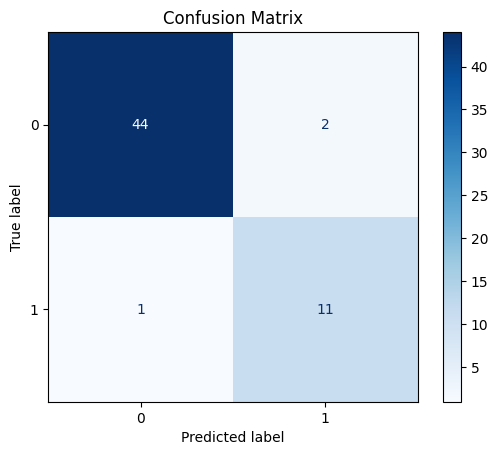

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

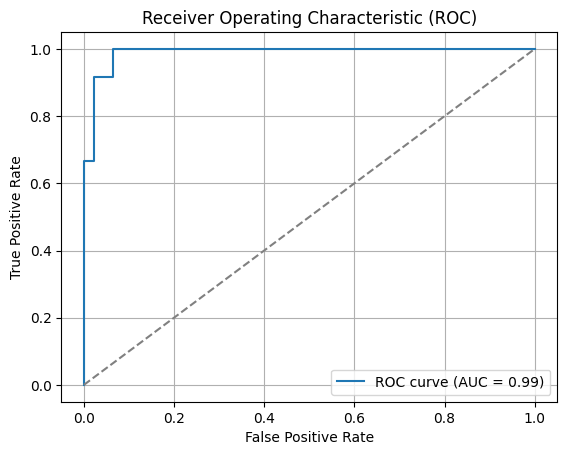

In [11]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()